In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import seaborn
import cv2

from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

In [3]:
from models_zoo.unet import UNet
from data.data import create_dataloader
from utils import load_model

In [4]:
%matplotlib inline

# Model

In [6]:
model = UNet()
model = load_model(model, "08-09-07-16.pth")
test_dataloader = create_dataloader(mode="test", num_samples=128, batch_size=32, shuffle=False, img_size=128)
img, mask = next(iter(test_dataloader))

Models is loaded from:  08-09-07-16.pth
128


In [7]:
pred = model(img).detach().numpy()
print(pred.shape)

(32, 2, 128, 128)


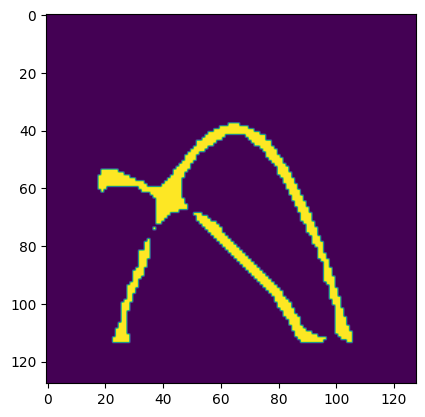

In [8]:
n = 12  # 14
origin = img[n]
my_img = pred[n][1]
my_img[my_img < 0.8] = 0
my_img[my_img > 0.5] = 1
my_img = np.roll(my_img, 0, axis=1)
plt.imshow(my_img)
plt.show()

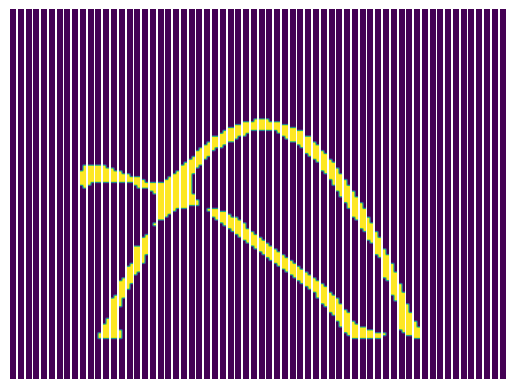

In [9]:
p_size = 2
n_piece = int(128 / p_size)

_, ax = plt.subplots(1, n_piece)
for i in range(n_piece):
    piece = my_img[:, i*p_size:(i+1)*p_size]
    ax[i].imshow(piece)
    ax[i].axis("off")

# Clustering

In [11]:
def get_cetners(img, n_of_cluster):
    y, x = np.where(img)
    kmeans = KMeans(n_clusters=n_of_cluster)
    kmeans.fit(np.column_stack((x, y)))
    return kmeans.cluster_centers_

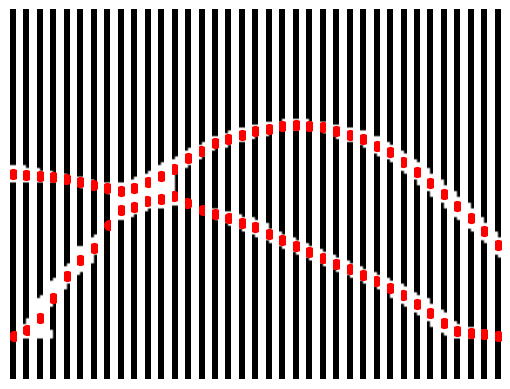

In [12]:
pice_n = 11

_, ax = plt.subplots(1, 48-pice_n)
for i in range(pice_n, 48): 
    piece = my_img[:, i*p_size:(i+1)*p_size]
    centers = get_cetners(piece, 2)
    ax[i-pice_n].imshow(piece, cmap='gray')
    ax[i-pice_n].scatter(centers[:, 0], centers[:, 1], c='red', s=50)
    ax[i-pice_n].axis("off")
plt.show()

# Utils

In [14]:
def relate_positions(positions, detections):
    object_positions = np.array(list(positions.values()))
    detection_positions = np.array(detections)
    cost_matrix = np.zeros((len(object_positions),
                            len(detection_positions)))
    for i, obj_pos in enumerate(object_positions):
        for j, det_pos in enumerate(detection_positions):
            cost_matrix[i, j] = np.linalg.norm(
                np.array(obj_pos) - np.array(det_pos))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignment = {
        list(positions.keys())[i]: detections[j] for i, j in zip(
            row_ind, col_ind)}
    return assignment

positions = {0: [22, 100], 1: [22, 18]}
detections = np.array([[22, 22], [22, 35], [24, 105]])

assignment = relate_positions(positions, detections)
assignment

{0: array([ 24, 105]), 1: array([22, 22])}

In [15]:
def diff(v1, v2):
    return np.array([v2[0] - v1[0],
                     v2[1] - v1[1]])

# VectorSlope

In [17]:
n_plots = 2

plots = {0: [(None, None), (None, None), (None, None)],
         1: [(None, None), (None, None), (None, None)]}

predictions = {0:[], 1:[]}
expectations = {0:[], 1:[]}

inertia = 0.8

for e, step in enumerate(range(11, 48)):
    piece = my_img[:, step*p_size:(step+1)*p_size]
    # get new centers
    detection = get_cetners(piece, n_of_cluster=n_plots)
    detection += np.array([step*p_size, 0])
    # fill x0
    if e == 0:
        for key in plots.keys():
            plots[key][0] = detection[key]
    # update x0, fill dx
    if e == 1:
        for key in plots.keys():
            expectations[key] = plots[key][0]
        new_x = relate_positions(expectations, detection)
        for key in plots.keys():
            new_dx = diff(new_x[key], plots[key][0])
            plots[key][1] = new_dx
            plots[key][0] = new_x[key]
    # update x0 and dx, fill dx2
    if e == 2:
        for key in plots.keys():
            expectations[key] = plots[key][0]
        new_x = relate_positions(expectations, detection)
        for key in plots.keys():
            new_dx = diff(plots[key][0], new_x[key])
            new_dx2 = diff(plots[key][1], new_dx)
            plots[key][2] = new_dx2
            plots[key][1] = new_dx
            plots[key][0] = new_x[key]
    if e > 2:
        for key in plots.keys():
            expectations[key] = plots[key][0] + 10 * plots[key][1] + 5 * plots[key][2]
        new_x = relate_positions(expectations, detection)
        for key in plots.keys():
            new_dx = inertia*new_dx + (1 - inertia)*diff(plots[key][0], new_x[key])
            new_dx2 = inertia*new_dx2 + (1 - inertia)*diff(plots[key][1], new_dx)
            plots[key][2] = new_dx2
            plots[key][1] = new_dx
            plots[key][0] = new_x[key]
            predictions[key].append(plots[key][0])

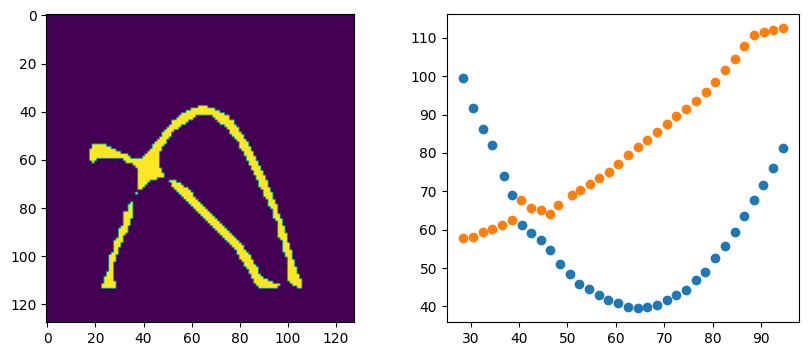

In [18]:
p0 = np.array(predictions[0])
p1 = np.array(predictions[1])

_, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].imshow(my_img)
ax[1].scatter(p0[:,0], p0[:,1])
ax[1].scatter(p1[:,0], p1[:,1])

Text(0.5, 1.0, 'Clustered')

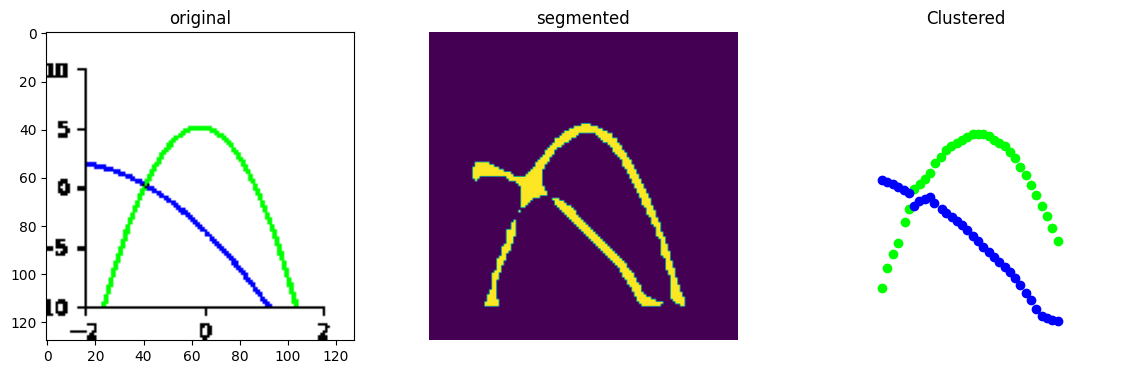

In [19]:
p0 = np.array(predictions[0])
p1 = np.array(predictions[1])

_, ax = plt.subplots(1, 3, figsize = (14, 4))
ax[0].imshow(np.transpose(origin, (1,2,0)))
ax[0].set_title("original")

ax[1].imshow(my_img)
ax[1].axis("off")
ax[1].set_title("segmented")

ax[2].scatter(p0[:,0], -p0[:,1], c = "lime")
ax[2].scatter(p1[:,0], -p1[:,1], c = "blue")
ax[2].set_ylim(-120, 0)
ax[2].set_xlim(0, 120)
ax[2].axis("off")
ax[2].set_title("Clustered")

# NumOfClusters

Cluster Centers:
 [[1.71428571 0.85714286]
 [5.28571429 3.71428571]]
2


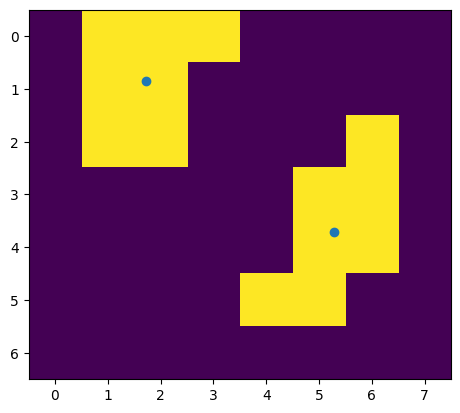

In [21]:
import numpy as np
from sklearn.cluster import DBSCAN

def find_cluster_centers(binary_mask, eps=2, min_samples=1):
    y, x = np.where(binary_mask)
    coordinates = np.column_stack((x, y))
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
    labels = db.labels_
    unique_labels = set(labels)
    unique_labels.discard(-1)
    cluster_centers = []
    for label in unique_labels:
        cluster_points = coordinates[labels == label]
        cluster_center = cluster_points.mean(axis=0)
        cluster_centers.append(cluster_center)
    return np.array(cluster_centers)

def estimate_cluster_num(binary_mask, eps=2, min_samples=1):
    y, x = np.where(binary_mask)
    coordinates = np.column_stack((x, y))
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
    labels = db.labels_
    unique_labels = set(labels)
    unique_labels.discard(-1)
    return len(unique_labels)

binary_mask = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
])

centers = find_cluster_centers(binary_mask)
print("Cluster Centers:\n", centers)

plt.imshow(binary_mask)
plt.scatter(centers[:, 0], centers[:, 1])

print(estimate_cluster_num(binary_mask))

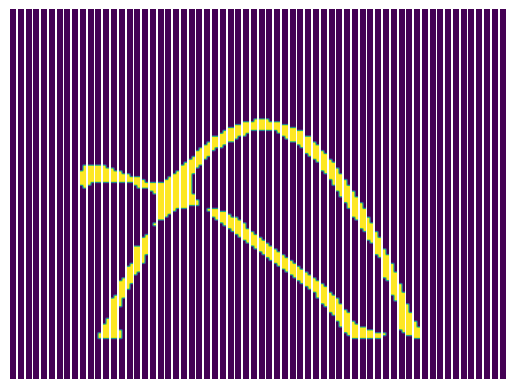

In [22]:
p_size = 2
n_piece = int(128 / p_size)

_, ax = plt.subplots(1, n_piece)
for i in range(n_piece):
    piece = my_img[:, i*p_size:(i+1)*p_size]
    ax[i].imshow(piece)
    ax[i].axis("off")

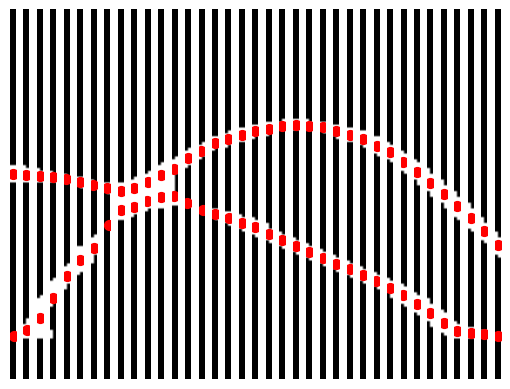

In [23]:
pice_n = 11

_, ax = plt.subplots(1, 48-pice_n)
for i in range(pice_n, 48): 
    piece = my_img[:, i*p_size:(i+1)*p_size]
    centers = get_cetners(piece, 2)
    ax[i-pice_n].imshow(piece, cmap='gray')
    ax[i-pice_n].scatter(centers[:, 0], centers[:, 1], c='red', s=50)
    ax[i-pice_n].axis("off")
plt.show()

we then need tree detections per each plot to set tree following parameters per plot: position (X), change of position (dX) and change of change of posiiton (dX2).
Based on these parameters we can estimate expected position on the coming plot as x + dx + dx2. Then new detections will be compared to the expected position and the nerest point to an expected posiotion will be asigned to a plot.

In [25]:
step_0 = 11
piece = my_img[:, i*p_size:(i+1)*p_size]
centers = get_cetners(piece, n_of_cluster=n_plots)
centers += np.array([i*p_size, 0])

In [26]:
n_plots = 2

kalmans = {"cl_1":cv2.KalmanFilter(4, 2), "cl_2":cv2.KalmanFilter(4, 2)}
expected_center = {"cl_1":[], "cl_2":[]}

for i, key in enumerate(kalmans.keys()):
    kalmans[key].transitionMatrix = np.array([[1, 0, 1, 0],
                                    [0, 1, 0, 1],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1]], dtype=np.float32)
    kalmans[key].measurementMatrix = np.array([[1, 0, 0, 0],
                                     [0, 1, 0, 0]], dtype=np.float32)
    kalmans[key].processNoiseCov = np.eye(4, dtype=np.float32) * 1e-2
    kalmans[key].measurementNoiseCov = np.eye(2, dtype=np.float32) * 1e-1
    kalmans[key].errorCovPost = np.eye(4, dtype=np.float32)
    kalmans[key].statePost = np.array([centers[i][0], centers[i][1], 0, 0], dtype=np.float32)
    expected_center[key] = centers[i]

In [ ]:
n_plots = 2
kalmans = {f'plot_{i}': initialize_kalman_filter() for i in range(n_plots)}
kalman_predictions = {f'plot_{i}': [] for i in range(n_plots)}

In [ ]:
def get_centers(img, n_of_cluster):
    y, x = np.where(img)
    kmeans = KMeans(n_clusters=n_of_cluster)
    kmeans.fit(np.column_stack((x, y)))
    return kmeans.cluster_centers_

In [ ]:
# modal class
# dependancy injection 

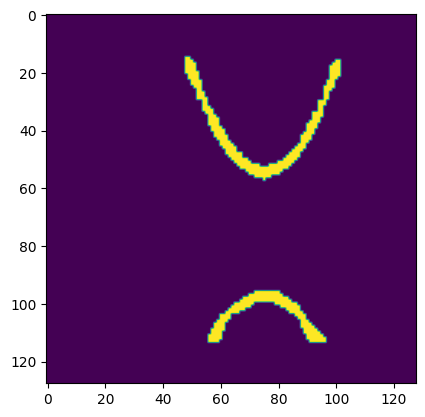

In [38]:
n = 11
origin = img[n]
my_img = pred[n][1]
my_img[my_img < 0.8] = 0
my_img[my_img > 0.5] = 1
plt.imshow(my_img)
plt.show()

In [40]:
class Tracker:

    def __init__(self):
        self.num_of_plots = 0
        self.kinetics = {}         # i:[(None, None), (None, None), (None, None)], ...
        self.trace = {}   # i:[(None, None), ...], ...
        self.expectations = {}  # i:(None, None)

class CCD:  # contineouse cluster detection

    def __init__(self, tracker_dict, iniertia: float = 0.8, velocity: float = 10, accelaration: float = 5):

        self.plots = tracker_dict
        self.inertia = iniertia
        self.n_missdetections = 0
        self.v = velocity
        self.a = accelaration
        self.cluster_counter = 0

    def get_cetners(self, img, n_of_cluster):
        """
        use KMean to find clusters centers
        """
        y, x = np.where(img)
        kmeans = KMeans(n_clusters=n_of_cluster)
        kmeans.fit(np.column_stack((x, y)))
        return kmeans.cluster_centers_

    def estimate_cluster_num(self, img, eps=2, min_samples=4):
        """
        use DBSCAN to estimate number of clsuters on an image
        """
        y, x = np.where(img)
        coordinates = np.column_stack((x, y))
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
        labels = db.labels_
        unique_labels = set(labels)
        unique_labels.discard(-1)
        return len(unique_labels)

    def show_pice(self, img, n_clusters):
        """
        shows a given img (piece of img)
        indicated number of detected cluster
        """
        plt.imshow(img)
        plt.title(n_clusters)
        plt.show()

    def n_clusters_controle(self, n_clusters):
        """
        controles number of cluster reduction
        to prevent missdetectins on intersections
        Less amount of clusters should be detected
            several times in a raw to be confirmed
        """
        if n_clusters < self.plots.num_of_plots:
            self.cluster_counter += 1
            if self.cluster_counter == 2:
                self.cluster_counter = 0
                return n_clusters
            else:
                return self.plots.num_of_plots
        else:
            self.cluster_counter = 0
            return n_clusters
        
    
    def assign(self, detections):
        """
        updates tracking objects with new positions;
        i. assign detectins to existin plots
            the rest is return for new plots update_positions()
        ii. new detections are added as new plots add_new_plots()
        iii. if new_positions are found
            then plots kinetics is updated update_kinetics()
        iv. expectations are updated with update_expectations()
        v. after all new detectins are added to trace
        """
        expectations = self.plots.expectations
        new_positions, new_detections = self.update_positions(expectations, detections)
        # a. add new plots
        self.add_new_plots(new_detections)
        # b. update kinetics
        if new_positions:
            self.update_kinetics(new_positions)
        # c. update expectations
        self.update_expectations()
        # d. update trace dict
        self.update_trace()
        
    def add_new_plots(self, new_detections):
        """
        adds new plot for new detections
        """
        for detection in new_detections:
            self.plots.kinetics[self.plots.num_of_plots] = [detection, (0, 0), (0, 0)]
            self.plots.trace[self.plots.num_of_plots] = []
            self.plots.num_of_plots += 1

    def update_kinetics(self, new_positions):
        """
        updating kinetics based on new detections and previouse positions;
        accounts inertia
        """
        for key in new_positions.keys():
            # new velocity
            dx_new = new_positions[key] - self.plots.kinetics[key][0]
            dx_last = np.array(self.plots.kinetics[key][1])
            # new acceleration
            dx2_new = dx_new - dx_last
            dx2_last = np.array(self.plots.kinetics[key][2])
            # updated kinetics
            self.plots.kinetics[key][2] = self.inertia * dx2_last + (1 - self.inertia) * dx2_new
            self.plots.kinetics[key][1] = self.inertia * dx_last + (1 - self.inertia) * dx_new
            self.plots.kinetics[key][0] = new_positions[key]

    def update_expectations(self):
        """
        updates expectations based on kinetics
        accounting velocity and acceleration coefficients
        """
        for key in self.plots.kinetics.keys():
            x = np.array(self.plots.kinetics[key][0])
            dx = np.array(self.plots.kinetics[key][1])
            dx2 = np.array(self.plots.kinetics[key][2])
            self.plots.expectations[key] = x + self.v * dx + self.a * dx2

    def update_trace(self):
        for key in self.plots.kinetics.keys():
            self.plots.trace[key].append(self.plots.kinetics[key][0])

    def update_positions(self, positions, detections, max_distance_threshold=None):
        """
        Related new detections to existing plots
        and returns remaining detectins to asign to new plots
        """
        object_positions = np.array(list(positions.values()))
        detection_positions = np.array(detections)
        num_objects = len(object_positions)
        num_detections = len(detection_positions)
        # Initialize and fill the cost matrix
        cost_matrix = np.zeros((num_objects, num_detections))
        for i, obj_pos in enumerate(object_positions):
            for j, det_pos in enumerate(detection_positions):
                cost_matrix[i, j] = np.linalg.norm(np.array(obj_pos) - np.array(det_pos))
        # Perform the assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        assignment = {}
        assigned_detections = set()
        for i, j in zip(row_ind, col_ind):
            if max_distance_threshold is None or cost_matrix[i, j] <= max_distance_threshold:
                assignment[list(positions.keys())[i]] = detections[j]
                assigned_detections.add(j)
        # Determine remaining detections
        remaining_detections = [detections[j] for j in range(num_detections) if j not in assigned_detections]
        return assignment, remaining_detections

    def run(self, my_img):
        """
        splits image into pieces and implements cluster tracking slice by slice"""
        for e, step in enumerate(range(0, 128)):
            # get piece of img
            piece = my_img[:, step * p_size : (step+1) * p_size]
            # n of cluster changed?
            if np.all(piece == 0):
                n_of_clusters = 0
            else:
                n_of_clusters = self.estimate_cluster_num(piece)
            # make detections
            if n_of_clusters > 0:
                n_of_clusters = self.n_clusters_controle(n_clusters=n_of_clusters)
                detections = self.get_cetners(piece, n_of_cluster=n_of_clusters)
                detections += np.array([step*p_size, 0])
                # now solving an asignment problem
                self.assign(detections)

Text(0.5, 1.0, 'Clustered')

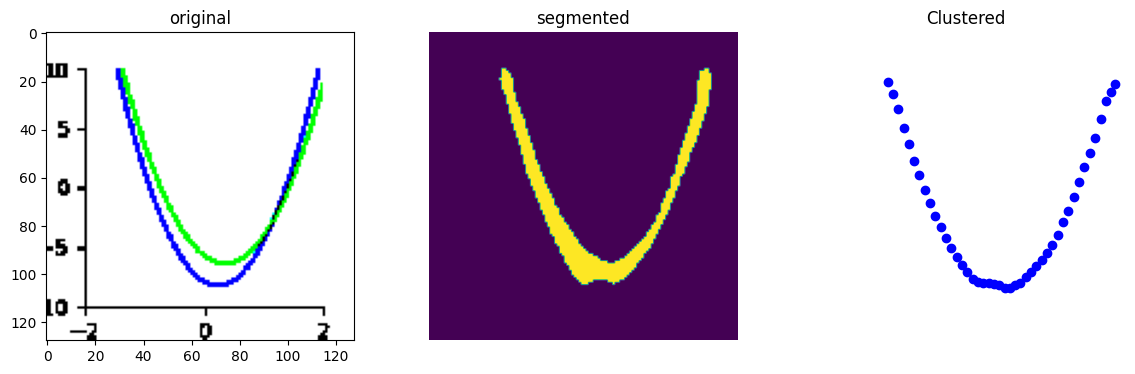

In [72]:
n = 8
origin = img[n]
my_img = pred[n][1]
my_img[my_img < 0.8] = 0
my_img[my_img > 0.5] = 1

tracker = Tracker()
obj = CCD(tracker, iniertia=0.7, velocity=1, accelaration=3)
obj.run(my_img)

trace = tracker.trace
plot1 = np.array(trace[0])
#plot2 = np.array(trace[1])

_, ax = plt.subplots(1, 3, figsize = (14, 4))
ax[0].imshow(np.transpose(origin, (1,2,0)))
ax[0].set_title("original")

ax[1].imshow(my_img)
ax[1].axis("off")
ax[1].set_title("segmented")

ax[2].scatter(plot1[:,0], -plot1[:,1], c = "blue")
#ax[2].scatter(plot2[:,0], -plot2[:,1], c = "lime")
ax[2].set_ylim(-120, 0)
ax[2].set_xlim(0, 120)
ax[2].axis("off")
ax[2].set_title("Clustered")